**Object Detection using pre-trained Model**

Author: Venkatesan Krishnamurthy

**Loading the essential libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import time
import os
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading Faster RCNN - Inception Resnet v2 model**

Trained on Openimages v4 dataset

In [ ]:
model_url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

model = hub.load(handle=model_url)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
detector = model.signatures["default"]

**Loading and Preprocessing Images**

In [ ]:
def load_and_preprocess_image(path):
  """
  Loads and preprocesses the image when its path is given

  Input:
  1. path: The path of the image

  Returns:
  1. image_tensor: preprocessed image in the form of a tensor [1, 640, 640, 3]
  """
  # Load and convert to array
  image_pil = tf.keras.preprocessing.image.load_img(path, color_mode='rgb', interpolation='nearest')
  image_array = tf.keras.preprocessing.image.img_to_array(image_pil)
  # Convert to tensor and add batch axis
  image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)[tf.newaxis, ...]
  # Resize and normalise the values
  image_tensor = tf.image.resize(image_tensor, size=(640, 640))
  image_tensor = image_tensor / 255.0
  
  return image_tensor

In [ ]:
image_1 = load_and_preprocess_image("/content/drive/MyDrive/Simple_Object_Detection/image_1.jpg")
image_2 = load_and_preprocess_image("/content/drive/MyDrive/Simple_Object_Detection/image_2.jpg")

**Display the Images**

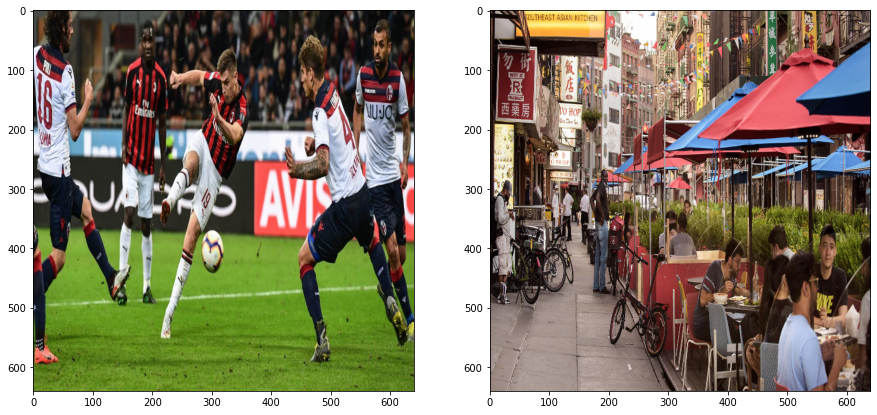

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(image_1.numpy()[0])
ax[1].imshow(image_2.numpy()[0])

**Detect Objects**

In [ ]:
start_time = time.time()
result_1 = detector(image_1)
result_2 = detector(image_2)
end_time = time.time()

print("Time Taken: " + str(round(end_time - start_time, 3)) + "s")

Time Taken: 83.198s


**Draw the bounding boxes on the Images**

In [ ]:
def draw_bounding_boxes(image, bounding_boxes, scores, class_names, max_boxes=10, color=(255, 0, 0), thickness=2):
  """
  Draws the bounding boxes on the image and displays their class names

  Inputs:
  1. image: The image for which objects were detected. Tensor of shape (1, h, w, 3)
  2. bounding_boxes: The bounding boxes that you get from detector. Tensor of shape (n, 4) The order of co-ordinates are (ymin, xmin, ymax, xmax)
  3. scores: The prediciton scores that you get from the detector. Tensor of shape (n)
  4. class_names: The class names that you get from the detector. Tensor (n)
  5. max_boxes: the maximum number of boxes you want to display on the image
  6. color: color to draw bounding box. Default is blue.
  7. thickness: rectangle thickness. Default value is 2.

  Returns
  The image with bounding boxes and class name

  """
  image_array = image.numpy()[0] #removing the batch dimension
  cv2_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB) * 255 # changing the channel order for opencv and rescaling by 255
  bb_array = bounding_boxes.numpy() # getting the numpy array out of the tensor

  image_width = image_array.shape[1]
  image_height = image_array.shape[0]
  # rescaling the bounding boxes according to size of the image
  bb_array_zero = bb_array[:,0] * image_height
  bb_array_one = bb_array[:,1] * image_width
  bb_array_two = bb_array[:,2] * image_height
  bb_array_three = bb_array[:,3] * image_width

  scaled_bb_array = np.vstack([bb_array_zero, bb_array_one, bb_array_two, bb_array_three])
  scaled_bb_array = scaled_bb_array.T

  count = 0
  for bounding_box, score, class_name in zip(scaled_bb_array, scores, class_names):
    if score > 0.1: # only draw bounding boxes whose prediction score was more than 0.1
      
      # to check if we reached max number of boxes
      if count < max_boxes:
        count += 1
      else:
        break

      ymin = bounding_box[0]
      xmin = bounding_box[1]
      ymax = bounding_box[2]
      xmax = bounding_box[3]
      name = str(class_name.numpy())[2:-1]
      disp = cv2.rectangle(cv2_image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)
      disp = cv2.putText(cv2_image, name, (int(xmin+5),int(ymin+15)), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,0), 2)

  return cv2_imshow(disp)


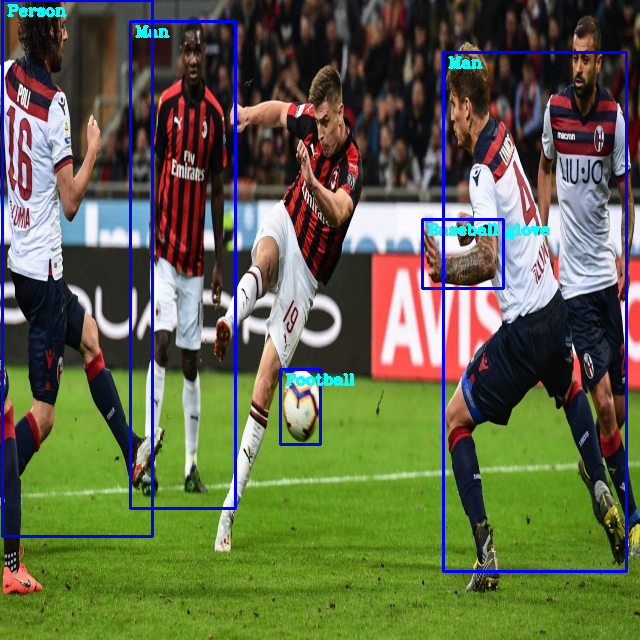

In [ ]:
draw_bounding_boxes(image_1, result_1["detection_boxes"], result_1["detection_scores"], result_1["detection_class_entities"], 5)

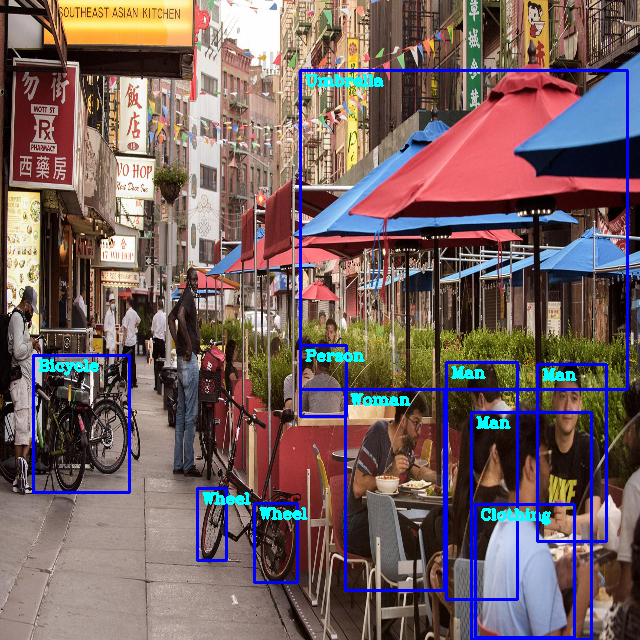

In [ ]:
draw_bounding_boxes(image_2, result_2["detection_boxes"], result_2["detection_scores"], result_2["detection_class_entities"])